In [46]:
import numpy as np

from numpy import loadtxt
from lmfit.models import GaussianModel,Model
from sklearn.linear_model import LinearRegression
from sklearn import mixture

from scipy.stats.distributions import norm
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde

    
from matplotlib import pyplot as plt
from matplotlib import cm

from scipy import ndimage as ndi
from scipy.spatial import distance
from numpy import linalg 

from skimage import io
from skimage.color import rgb2gray

from PIL import Image, ImageDraw, ImageFilter,ImageOps
import copy
import cv2

import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt as edt

from skimage.draw import ellipse
from skimage.measure import find_contours, approximate_polygon,subdivide_polygon



from grain_utils import grainPreprocess,grainShow,grainMark,grainDraw


In [200]:
grain1_name='Ultra_Co6_2'
grain2_name='Ultra_Co8'
grain3_name='Ultra_Co11'
grain4_name='Ultra_Co15'
grain5_name='Ultra_Co25'

grain1_file_name=grain1_name+'.jpg'
grain2_file_name=grain2_name+'.jpg'
grain3_file_name=grain3_name+'.jpg'
grain4_file_name=grain4_name+'.jpg'
grain5_file_name=grain5_name+'.jpg'
path='images'

grain1_pil=Image.open(path+'/'+grain1_file_name)
grain2_pil=Image.open(path+'/'+grain2_file_name)
grain3_pil=Image.open(path+'/'+grain3_file_name)
grain4_pil=Image.open(path+'/'+grain4_file_name)
grain5_pil=Image.open(path+'/'+grain5_file_name)


h=150
image1=grainPreprocess.image_preprocess(grain1_pil,h=h)
image2=grainPreprocess.image_preprocess(grain2_pil,h=h)
image3=grainPreprocess.image_preprocess(grain3_pil,h=h)
image4=grainPreprocess.image_preprocess(grain4_pil,h=h)
image5=grainPreprocess.image_preprocess(grain5_pil,h=h)

D:\PROJECTS\python\grain_segmentation\grain_utils.py:47: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  image=rgb2gray(img)


In [ ]:
cnt=grainMark.get_contours(image1)
img=grainDraw.draw_edges(image1,cnt,color=(50,50,50))
#grainShow.img_show(img,15)

In [304]:
def gaussian(x, mu, sigma,amp=1):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return (amp/(np.sqrt(2*np.pi)*sigma))*np.exp(-(x-mu)**2 / (2*sigma**2))

def bimodal(x,mu1,sigma1,amp1,mu2,sigma2,amp2):
    return gaussian(x,mu1,sigma1,amp1)+gaussian(x,mu2,sigma2,amp2)

def gaussian_fit(y , x):
    gmodel = Model(gaussian)
    res = gmodel.fit(y, x=x, mu=1,sigma=25,amp=1)

    return res


def gaussian_fit_bimodal(y , x):
    gmodel = Model(bimodal)
    res = gmodel.fit(y, x=x, mu1=100,sigma1=30,amp1=1,mu2=240,sigma2=30,amp2=1)

    return res

In [6]:
def angles_approx(images,names,step,N):
    text=[]
    plt.figure(figsize=(N,N))
    for j,image in enumerate(images):
        angles,angles_set,dens_curve=angle_estimate(image,step)
        
        x = np.array(angles_set)
        y = np.array(dens_curve)

        norm=np.sum(y)
        gmm = mixture.GaussianMixture(n_components=2, max_iter=10000, covariance_type='full').fit(angles.reshape(-1,1))

        mus=gmm.means_
        sigmas=gmm.covariances_
        print('new angles')      
        print('mus',mus)
        print('sigmas',sigmas)
        
        gauss=np.array(bimodal(x,mus[0],sigmas[0],1,mus[1],sigmas[1],1))[0]
        
      #  plt.plot(x, pdf, color='blue', alpha=0.5, lw=3)
   #     plt.plot(x,y/norm)
        plt.plot(x,gauss)
       # plt.fill(x,y)

    legend=[]
 #   for k,name in enumerate(names):
 #       legend.append(name+' '+text[k])
        
 #   plt.legend(legend,fontsize=15)
    plt.ylabel('количество углов/количество пустот, шт', fontsize=20)
    plt.xlabel('угол связующего вещества, градусы', fontsize=20)
    plt.savefig('крупные_средние_мелкие.png')
    plt.show() #крупные

In [317]:
def angles_approx(images,names,step,N,font_size=20):
    #
    # хорошая аппроксимация 
    #
    for j,image in enumerate(images):
        
        original_angles=grainMark.get_angles(image)
        angles,angles_set,dens_curve=grainMark.get_statistics(original_angles,step)
        
        x = np.array(angles_set)
        y = np.array(dens_curve)

        norm=np.sum(y)
        bandwidth=0.5
        kde = gaussian_kde(angles, bw_method=bandwidth / x.std(ddof=1))
        pdf=kde.evaluate(x)
        
        res=gaussian_fit_bimodal(y,x)
        
        mus=[res.params['mu1'].value,res.params['mu2'].value]
        sigmas=[res.params['sigma1'].value,res.params['sigma2'].value]
        amps=[res.params['amp1'].value,res.params['amp2'].value]

        x_gauss=range(0,361)
        
        gauss=np.array(bimodal(x_gauss,mus[0],sigmas[0],amps[0],mus[1],sigmas[1],amps[1]))
        

     #   plt.legend(text,fontsize=15)
     #   plt.plot(x,y/norm)
     #   plt.hist(angles,bins=100)

        mu1=round(mus[0],2)
        sigma1=round(sigmas[0],2)
        amp1=round(amps[0]/norm,2)
        
        mu2=round(mus[1],2)
        sigma2=round(sigmas[1],2)
        amp2=round(amps[1]/norm,2)

        moda1='\n mu1 = '+str(mu1)+' sigma1 = '+str(sigma1)+' amp1 = '+str(amp1)
        moda2='\n mu2 = '+str(mu2)+' sigma2 = '+str(sigma2)+' amp2 = '+str(amp2)
        val=round(np.log(norm),4)
        total_number='\n количество углов  $e^{'+str(val)+'}$'
        text_angle='\n шаг угла '+str(step)+' градусов'
        text=names[j]+moda1+moda2+total_number+text_angle
        
        plt.figure(figsize=(N,N))
        plt.plot(gauss/norm)
        plt.scatter(x,y/norm)
        plt.legend([text],fontsize=font_size)
        plt.ylabel('p(x)', fontsize=font_size)
        plt.xlabel('угол связующего вещества, градусы', fontsize=font_size)
        
        
      #  plt.savefig('крупные_средние_мелкие.png')
      #  plt.savefig('углы_'+names[j])
        plt.show() #крупные

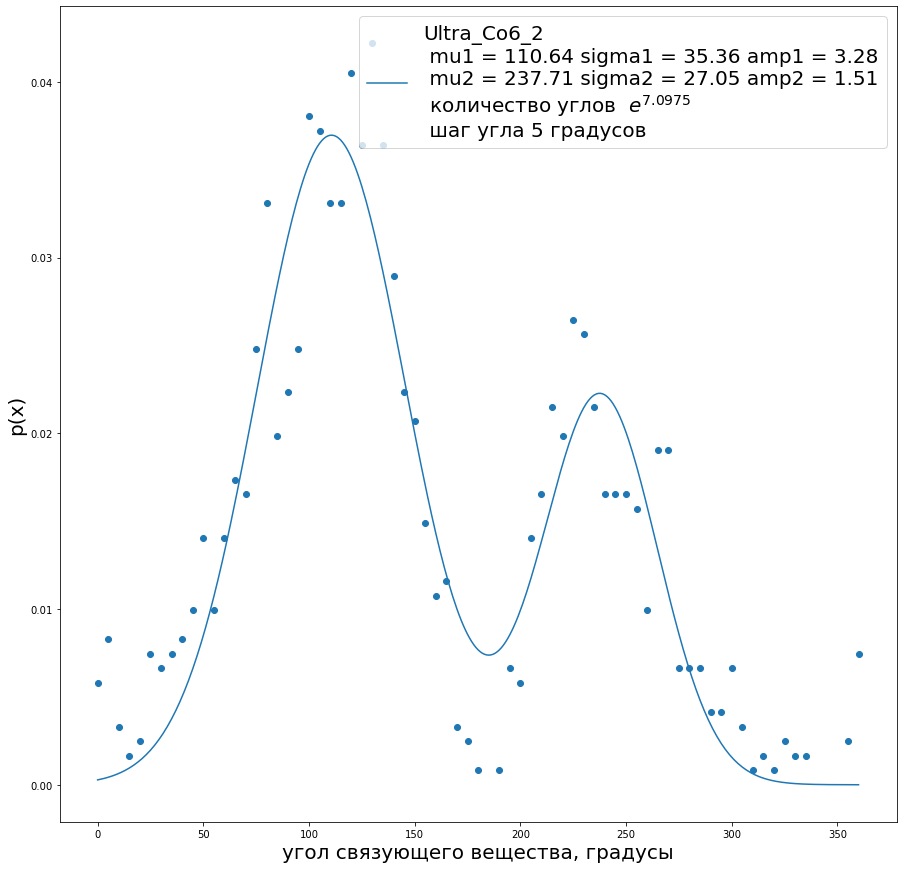

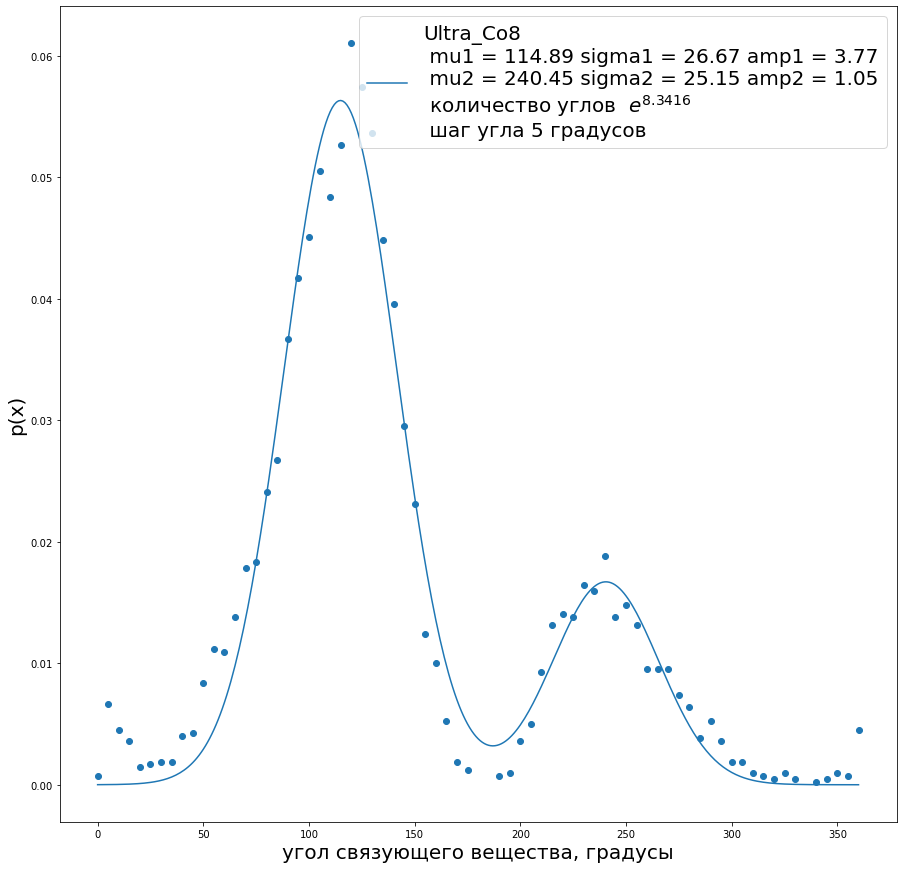

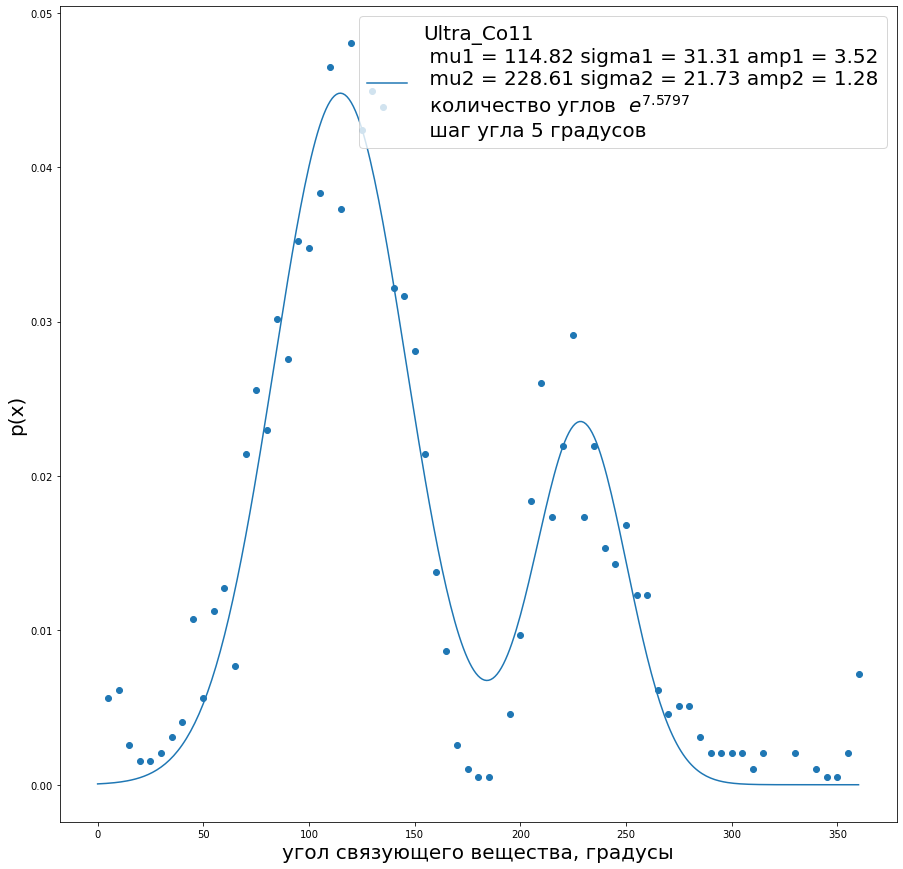

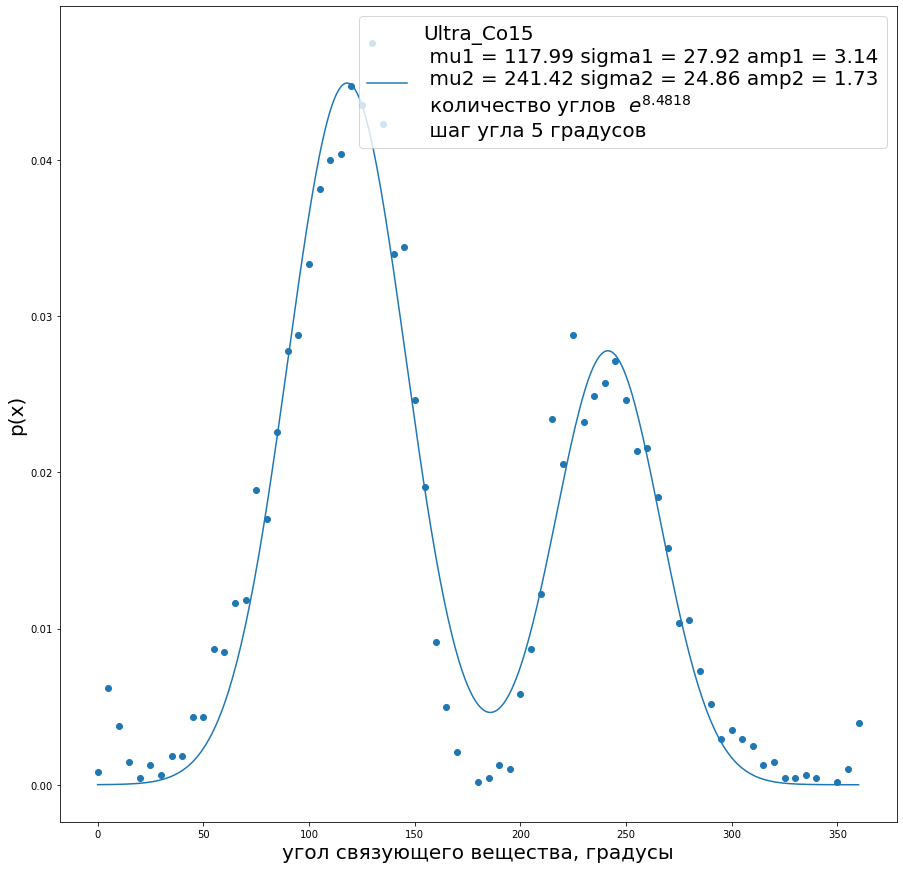

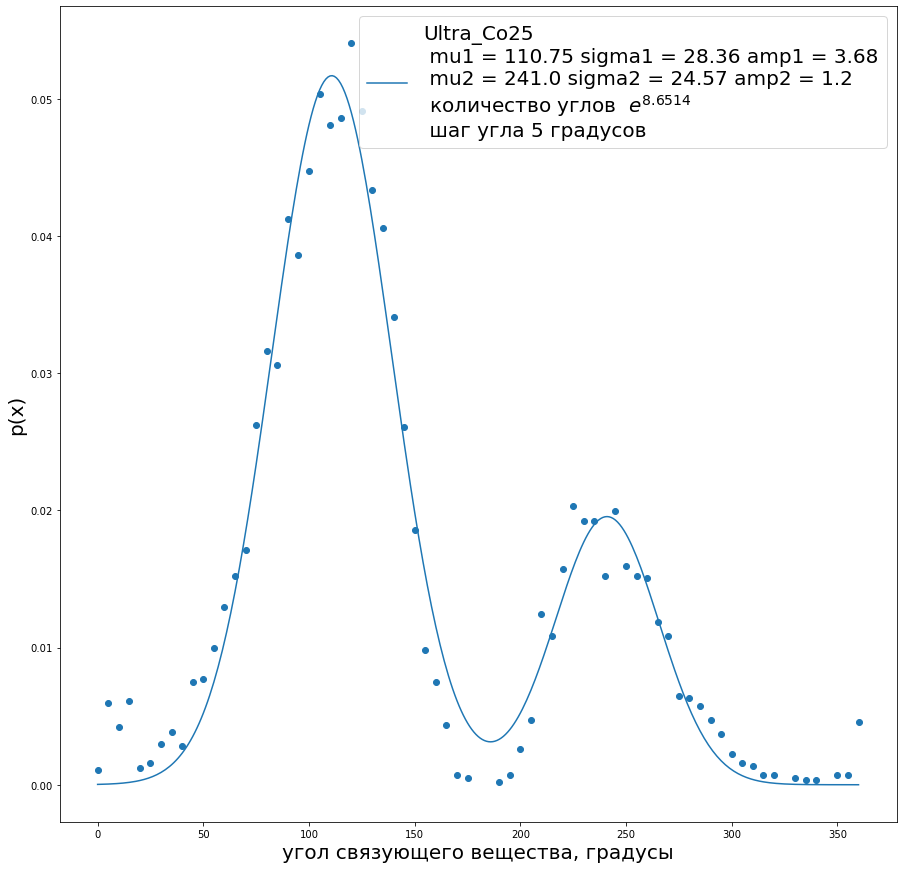

In [318]:
N=15

images=[image1,image2,image3,image4,image5]
#images=[image2]
step=5
names=[grain1_name,grain2_name,grain3_name,grain4_name,grain5_name]
#names=['сплав с крупными зернами']
angles_approx(images,names,step,N)

## Распределение диаметров

In [236]:
def diametr_approx(images,names,step,pixel,N):
    text=[]
    bins=150

    for j,image in enumerate(images):
        original_diametrs=grainMark.get_diametrs(image)
        distances,dist_set,dens_curve=grainMark.get_statistics(original_diametrs,step)
        
        
        x = np.array([dist_set]).reshape(-1, 1)
        y = np.log([dens_curve]).reshape(-1, 1)
        norm=round(np.sum(y),6)
        y=y/norm

        bandwidth=0.5
    #    kde = gaussian_kde(distances, bw_method=bandwidth / x.std(ddof=1))
     #   pdf=kde.evaluate(x)
        
     #   res=gaussian_fit(y,x)
        
  #      mu=res.params['mu'].value
   #     sigma=res.params['sigma'].value
   #     amp=res.params['amp'].value

        x_linear=np.arange(1,x.max(axis=0)).reshape(-1, 1)

        reg = LinearRegression().fit(x,y)

        lin_predict=reg.predict(x_linear)
        
        k=round(reg.coef_[0][0]*1000,3)
        score=round(reg.score(x, y),2)
        
    #    gauss=np.array(gaussian(x_gauss,mu,sigma,amp))
       # text.append('sigma='+str(round(sigma1,2))+' mu=' +str(round(mu1,2)))
        plt.figure(figsize=(N,N))
    #    plt.hist(distances,bins=bins)
    #    plt.plot(x,np.log(y))
        plt.plot(x_linear*pixel,lin_predict)
     #  plt.hist(angles,bins=100)
    #    plt.plot(gauss/norm)
        plt.scatter(x*pixel,y)
        val=pixel*step
        plt.legend([names[j]+'\n k = '+str(k)+'$*10^{-3}$ \n точность = '+str(score)+'\n количество диаметров = $e^{'+str(norm)+'}$'+'\n шаг длины диаметра step  = '+str(val)+'$ мкм$'],fontsize=20)
        plt.ylabel('ln(p(x))', fontsize=20)
        plt.xlabel('диаметр региона связ. вещества, мкм', fontsize=20)
     #   plt.savefig('крупные_средние_мелкие.png')
     #   plt.savefig('диаметр_'+names[j])
        plt.show()

        
    


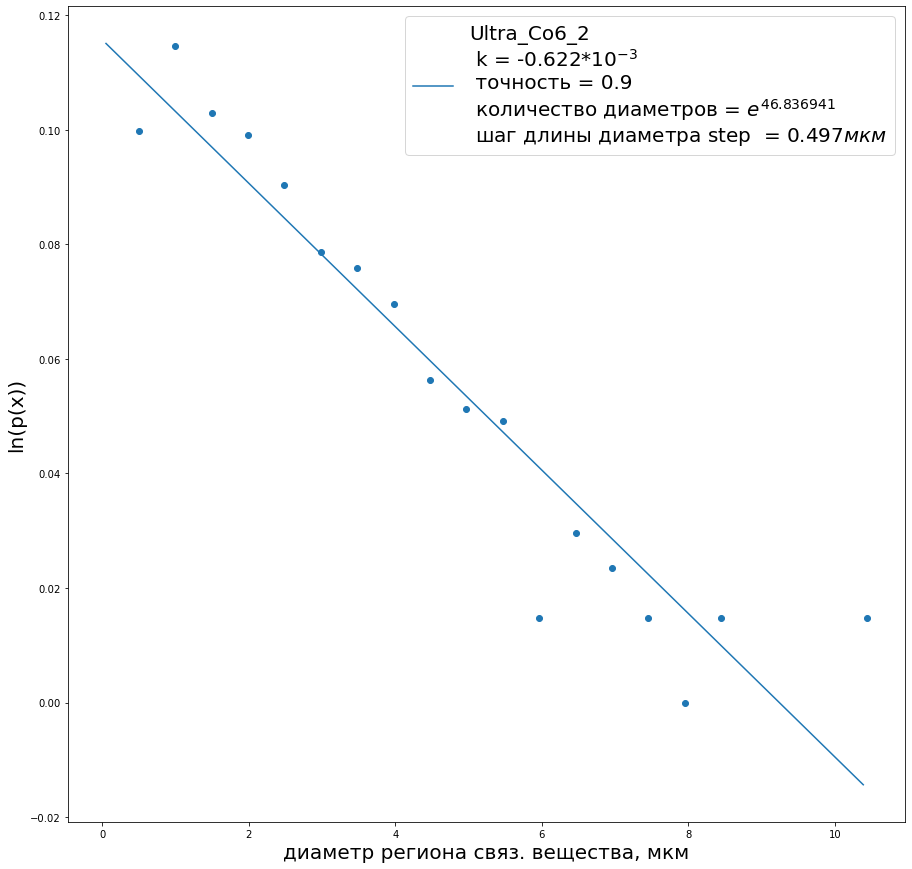

In [239]:
N=15
pixel=49.7/1000
images=[image1,image2,image3,image4,image5]
images=[image2]
step=10
names=[grain1_name,grain2_name,grain3_name,grain4_name,grain5_name]
#names=['сплав с крупными зернами']
diametr_approx(images,names,step,pixel,N)